## Interpolazione delle curve di Gumbel con il metodo dei minimi quadrati

Il metodo dei momenti consiste nel minimizzare lo scarto quadratico $\delta^2$ 
tra le misure di ECDF (frequenza empirica di non superamento) e la probabilità di non superamento:
\begin{equation} 
\delta^2(a,b) = \sum_i^N (ECDF_i-P[h_i;a,b])^2
\to \rm min(\delta^2(a,b))
\end{equation}

In [4]:
from scipy.stats import norm
from scipy.stats import genextreme,gumbel_r
import numpy as np
from numpy import linspace
from pylab import plot,show,hist,figure,title

In [5]:
import os
import math
from pandas import *
import pandas as pd
from datetime import datetime
%matplotlib inline 
import matplotlib.pyplot as plt

In [6]:
data = pd.read_csv('PluviometriaVE.txt')
map(datetime,data['anno'])
data=data.set_index('anno')

In [7]:
data.head()

,1h,3h,6h,12h,24h
anno,,,,,
2000,36.2,36.2,62.0,73.2,93.2
2001,37.0,52.8,55.0,69.8,78.8
2002,41.8,55.4,58.2,59.0,60.0
2003,25.8,29.8,31.0,41.0,46.8
2004,21.2,28.0,39.0,45.6,61.6


Per minimizzare il valore di $\delta^2$ bisogna risolvere un sistema non lineare di due equazioni in funzione dei parametri $a$ e $b$,con un opportuno metodo numerico. 

In [8]:
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.optimize import least_squares 

Definiamo in questo modo la funzione di Gumbel, dove x[0] e x[1] sono parte di un vettore. È necessario definire la funzione in questo modo in quanto sarà poi richiesta da un algoritmo in seguito.

In [9]:
def fun(x,t,y):
    return np.exp(-np.exp(-(t-x[0])/x[1]))-y

In [10]:
from scipy.optimize import least_squares

Assegno l'ipotesi iniziale $x_0$ per ogni durata ai risultati ottenuti con il metodo dei momenti (valori, quindi, che sappiamo già essere plausibili).
Il problema dei metodi iterativi è infatti che è necessario imporre questa ipotesi sulla posizione dei parametri per poter procedere con la risoluzione:

In [11]:
ecdf1h = ECDF(data["1h"])
x0=[31.,15.]

In [12]:
data['1h'].head()

anno
2000    36.2
2001    37.0
2002    41.8
2003    25.8
2004    21.2
Name: 1h, dtype: float64

Per poter applicare il metodo inoltre devo ordinare i dati in ordine crescente e calcolo le ordinate corrispondenti ai dati:

In [13]:
t_train=sorted(data["1h"])
y_train=ecdf1h(t_train)

Calcolo l'ordinata corrispondente ai dati:

In [14]:
y_train=ecdf1h(t_train)

A questo punto posso applicare il metodo dei minimi quadrati, utilizzando la funzione fun che era stata introdotta prima e l'ipotesi iniziale $x_0$:

In [15]:
res_lsq_1h=least_squares(fun,x0,args=(t_train,y_train))
res_lsq_1h.x 


array([29.83773928, 15.96934665])

È poi possibile ripetere i passaggi per ogni durata, cambiando il valore dell'ipotesi iniziale $x_0$:

In [16]:
ecdf3h=ECDF(data['3h'])
t_rain=sorted(data['3h'].dropna())
y_train=ecdf3h(t_train)
x0=[39.,19.]
res_lsq_3h=least_squares(fun,x0,args=(t_train,y_train))


In [17]:
ecdf6h=ECDF(data['6h'])
t_rain=sorted(data['6h'].dropna())
y_train=ecdf6h(t_train)
x0=[45.,21.]
res_lsq_6h=least_squares(fun,x0,args=(t_train,y_train))
res_lsq_6h.x

array([44.9276428 , 16.19723798])

In [18]:
ecdf12h=ECDF(data['12h'])
t_rain=sorted(data['12h'].dropna())
y_train=ecdf12h(t_train)
x0=[54.,21.]
res_lsq_12h=least_squares(fun,x0,args=(t_train,y_train))
res_lsq_12h.x

array([53.71105246, 18.27698429])

In [19]:
ecdf24h=ECDF(data['24h'])
t_rain=sorted(data['24h'].dropna())
y_train=ecdf24h(t_train)
#deduco un nuovo x0 dai valori ottenuti per 12h
x0=[64.,23.]
res_lsq_24h=least_squares(fun,x0,args=(t_train,y_train))
res_lsq_24h.x

array([63.23900778, 21.52475381])

In [20]:
ab_mq=pd.DataFrame([res_lsq_1h.x,res_lsq_3h.x,res_lsq_6h.x,res_lsq_12h.x,res_lsq_24h.x],
                    columns=['a','b'],
                    index=['1h','3h','6h','12h','24h']).T
ab_mq

,1h,3h,6h,12h,24h
a,29.837739,37.931925,44.927643,53.711052,63.239008
b,15.969347,17.954823,16.197238,18.276984,21.524754


In [21]:
ab_mq.to_pickle("ab_mq")

Definisco la funzione di Gumbel, la quale prenderà i valori dei parametri $a$ e $b$ appena trovati:

In [22]:
from statsmodels.distributions.empirical_distribution import ECDF
def gumbel(x,ab_d,col):
    return np.exp(-np.exp(-(x-ab_d[col]["a"])/ab_d[col]["b"]))

from scipy.stats import genextreme,gumbel_r
from numpy import linspace

t_rain=np.linspace(data.min()[0],data.max()[4],100)

In [23]:
gb=pd.DataFrame([gumbel(t_rain,ab_mq,"1h"),
                 gumbel(t_rain,ab_mq,"3h"),
                 gumbel(t_rain,ab_mq,"6h"),
                 gumbel(t_rain,ab_mq,"12h"),
                 gumbel(t_rain,ab_mq,"24h")]).T
gb.index=t_rain
gb.columns=["1h","3h","6h","12h","24h"]
gb.head()

,1h,3h,6h,12h,24h
12.000000,0.047091,0.014424,0.000483,0.000056,0.000020
13.424242,0.061118,0.019929,0.000918,0.000116,0.000040
14.848485,0.077578,0.026864,0.001654,0.000229,0.000077
16.272727,0.096488,0.035396,0.002835,0.000428,0.000141
17.696970,0.117794,0.045668,0.004645,0.000766,0.000249


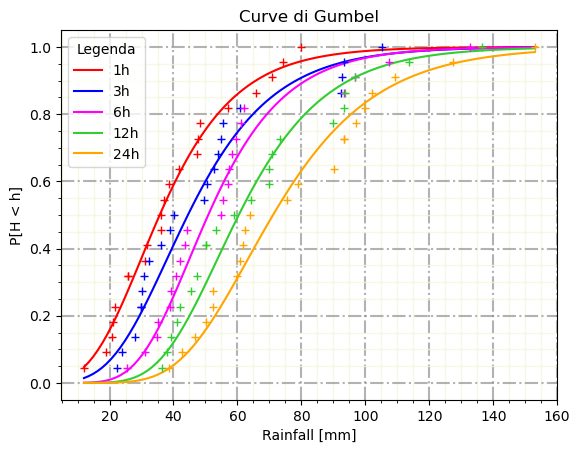

In [25]:
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10) 
plt.style.use('default')
ax=gb.plot(color=["red","blue","magenta","limegreen","orange"])
ecdf1h = ECDF(data["1h"])
ax.plot(data["1h"],ecdf1h(data["1h"]),'+',c="red", label="1h",markersize=6) 
data3h=data["3h"]
ecdf3h = ECDF(data3h)
ax.plot(data3h,ecdf3h(data3h),"+",c="blue", label="3h",markersize=6)
data6h=data["6h"]
ecdf6h = ECDF(data6h)
ax.plot(data6h,ecdf6h(data6h),"+",c="magenta", label="6h",markersize=6)
data12h=data["12h"]
ecdf12h = ECDF(data12h)
ax.plot(data12h,ecdf12h(data12h),"+",c="limegreen", label="12h",markersize=6)
data24h=data["24h"]
ecdf24h = ECDF(data24h)
ax.plot(data24h,ecdf24h(data24h),"+",c="orange", label="24h",markersize=6)
ax.set_title('Curve di Gumbel')
ax.set_xlabel('Rainfall [mm]')
ax.set_ylabel('P[H < h]')
ax.set_aspect('auto')

#major grid lines
plt.grid(b=True, which='major', color='gray', alpha=0.6, linestyle='dashdot', lw=1.5)
#minor grid lines
plt.minorticks_on()
plt.grid(b=True, which='minor', color='beige', alpha=0.8, ls='-', lw=1)

plt.legend(['1h', '3h', '6h', '12h', '24h'], loc='right',  title = "Legenda", title_fontsize = 10)

plt.show()


Così facendo, è possibile calcolare i dati delle curve di Gumbel con tutti e tre i metodi.
Fatto questo, è necessario scegliere quale coppia $a$ e $b$ tra le tre trovate sia la migliore e a questo fine si introduce il test di Pearson.